<a href="https://colab.research.google.com/github/svvuae/Python_Study/blob/main/SEE912_Q2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download training and testing dataset from google drive**

In [2]:
import gdown
folder_id = '1sR02CtcPKx5ulQ8o0Y7598IbwvUF4kT0'
gdown.download_folder(id=folder_id, quiet=False, output="dataset")

Retrieving folder contents


Processing file 1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_ test.zip
Processing file 19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y train.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_
To: /content/dataset/test.zip
100%|██████████| 6.28M/6.28M [00:00<00:00, 107MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y
From (redirected): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y&confirm=t&uuid=682c2e48-a301-4d60-83a3-53f847282623
To: /content/dataset/train.zip
100%|██████████| 44.2M/44.2M [00:00<00:00, 98.1MB/s]
Download completed


['dataset/test.zip', 'dataset/train.zip']

**Extracting downloaded training and testing dataset zip files**

In [3]:
import zipfile
def extract_zip(zip_file_path, extract_to='.'):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
zip_file_path = '/content/dataset/test.zip'
extract_zip(zip_file_path, './dataset')
zip_file_path = '/content/dataset/train.zip'
extract_zip(zip_file_path, './dataset')

In [12]:
import pathlib
test_solar_dir = pathlib.Path('/content/dataset/test/solar')
test_solar = list(test_solar_dir.glob('*.jpg'))
test_nosolar_dir = pathlib.Path('/content/dataset/test/nosolar')
test_nosolar = list(test_nosolar_dir.glob('*.jpg'))
test_dir = pathlib.Path('/content/dataset/test')

112


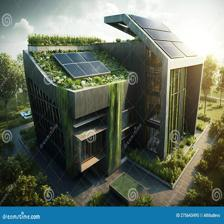

In [5]:
print(len(test_solar))
PIL.Image.open(str(test_solar[0]))

200


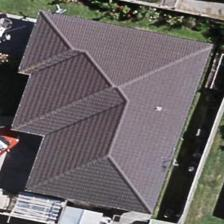

In [6]:
print(len(test_nosolar))
PIL.Image.open(str(test_nosolar[0]))

In [11]:
train_solar_dir = pathlib.Path('/content/dataset/train/solar')
train_solar = list(train_solar_dir.glob('*.jpg'))
train_nosolar_dir = pathlib.Path('/content/dataset/train/nosolar')
train_nosolar = list(train_nosolar_dir.glob('*.jpg'))
train_dir = pathlib.Path('/content/dataset/train')


523


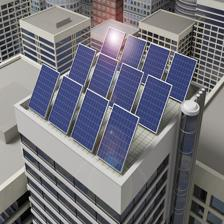

In [8]:
print(len(train_solar))
PIL.Image.open(str(train_solar[0]))

900


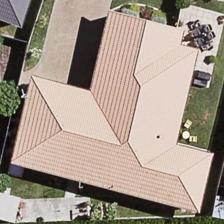

In [9]:
print(len(train_nosolar))
PIL.Image.open(str(train_nosolar[0]))

In [13]:
img_height = 180
img_width = 180
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 1800 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [14]:
classnames = train_ds.class_names
print(classnames)

['nosolar', 'solar']


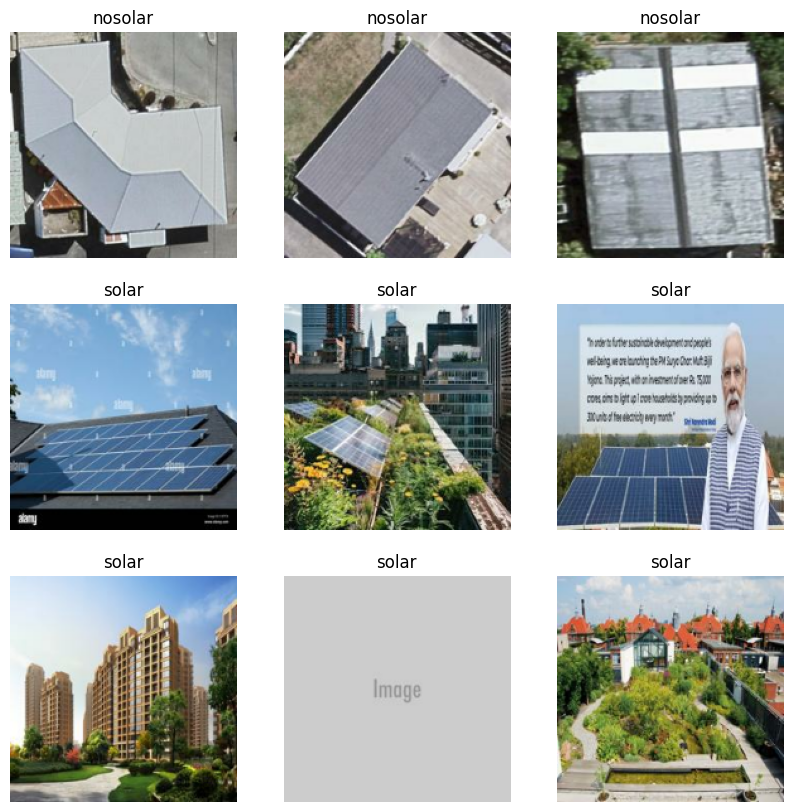

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Tuning to improve performance**

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Training dataset Normalization**

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.00016317287 0.9870035


**1. Training using normal multilayer perceptron (MLP)**

In [20]:
model = keras.Sequential(
    [
        keras.Input(shape=(180, 180, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [22]:
import time
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.7199 - loss: 477.3488 - val_accuracy: 0.9300 - val_loss: 37.6869
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.8883 - loss: 71.3359 - val_accuracy: 0.9525 - val_loss: 9.2566
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.9097 - loss: 23.3816 - val_accuracy: 0.8475 - val_loss: 36.6420
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.9099 - loss: 26.0865 - val_accuracy: 0.9450 - val_loss: 14.5105
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.8882 - loss: 26.6550 - val_accuracy: 0.9625 - val_loss: 7.9603
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 296ms/step - accuracy: 0.9002 - loss: 25.6814 - val_accuracy: 0.9550 - val_loss: 12.0290
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.9108 - loss: 19.4055 - val_accuracy: 0.9325 - val_loss: 12.0638
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.9445 - loss: 13.2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,441,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,325,573 (142.39 MB)

 Trainable params: 12,441,857 (47.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,883,716 (94.92 MB)

Test accuracy: 0.9649999737739563
Training time: 182.1016538143158


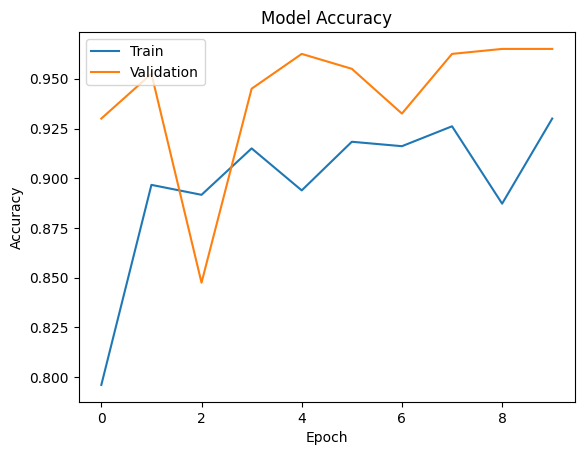

Average Training Time per Epoch: 18.21016538143158


In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**2. Training using CNN with only 1 hidden layers**

In [24]:
model = keras.Sequential(
    [
        keras.Input(shape=(180, 180, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [25]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 781ms/step - accuracy: 0.6706 - loss: 866.6017 - val_accuracy: 0.9775 - val_loss: 3.6960
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 760ms/step - accuracy: 0.9655 - loss: 6.0048 - val_accuracy: 0.9950 - val_loss: 0.2258
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 768ms/step - accuracy: 0.9909 - loss: 0.7168 - val_accuracy: 0.9950 - val_loss: 0.3187
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 769ms/step - accuracy: 0.9977 - loss: 0.1325 - val_accuracy: 0.9975 - val_loss: 0.1809
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 762ms/step - accuracy: 0.9975 - loss: 0.0741 - val_accuracy: 0.9975 - val_loss: 0.1651
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 761ms/step - accuracy: 0.9981 - loss: 0.0450 - val_accuracy: 0.9950 - val_loss: 0.5372
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 796ms/step - accuracy: 0.9934 - loss: 0.3750 - val_accuracy: 0.9875 - val_loss: 1.7085
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 766ms/step - accuracy: 0.9986 - loss: 0.0697 - val_ac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         253,473 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 763,109 (2.91 MB)

 Trainable params: 254,369 (993.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,740 (1.94 MB)

Test accuracy: 0.9975000023841858
Training time: 706.6469173431396


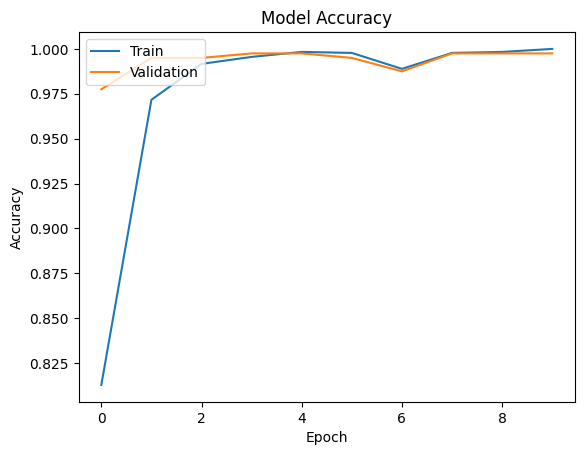

Average Training Time per Epoch: 70.66469173431396


In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**3. Training using CNN with multiple hidden layers**

In [ ]:
def create_and_train_cnn(num_hidden_layers, num_kernels):
    model = keras.Sequential()
    model.add(keras.Input(shape=(180, 180, 3)))
    for i in range(num_hidden_layers):
        model.add(layers.Conv2D(num_kernels, kernel_size=(3, 3), activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(train_ds, epochs=10, validation_data=test_ds)
    end_time = time.time()
    training_time = end_time - start_time
    model.summary()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({num_hidden_layers} hidden layers, {num_kernels} kernels)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    epochs = len(history.history['accuracy'])
    time_per_epoch = training_time / epochs
    print("Average Training Time per Epoch:", time_per_epoch)

configurations = [
    (1, 32),  # 1 hidden layer, 32 kernels
    (2, 64),  # 2 hidden layers, 64 kernels
    (3, 128)  # 3 hidden layers, 128 kernels
]

for num_hidden_layers, num_kernels in configurations:
    create_and_train_cnn(num_hidden_layers, num_kernels)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 766ms/step - accuracy: 0.7298 - loss: 468.5263 - val_accuracy: 0.9925 - val_loss: 2.3097
Epoch 2/10


**4. Training using ResNet50**


In [ ]:
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

end_time = time.time()
training_time = end_time - start_time
model.summary()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (ResNet50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)